### Forecast de demanda: Facturapp

#### ✅ Prophet

##### Datos

In [1]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

In [2]:
import pandas as pd

# Rutas a los archivos CSV
clientes_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/clientes.csv'
productos_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/productos.csv'
ventas_path = 'C:/Others/Emprendiendo/Agencia/Bummi ai/GitHub Bummi/forecast_facturapp/csv/ventas.csv'

# Leer los archivos CSV
clientes_df = pd.read_csv(clientes_path)
productos_df = pd.read_csv(productos_path)
ventas_df = pd.read_csv(ventas_path)

In [3]:
# Lista de códigos de producto que quieres filtrar
codigos_producto = ['60']

# Filtrar el DataFrame original para que solo incluya las filas con los códigos de producto especificados
ventas_filtradas_df = ventas_df[ventas_df['codigo_producto'].isin(codigos_producto)]

# Crear la tabla agregada con los datos filtrados
tabla_agrupada = ventas_filtradas_df.groupby('fecha_venta').agg(
    cantidad_ventas_producto=pd.NamedAgg(column='cantidad_ventas_producto', aggfunc='sum')
).reset_index()

# Pivotear las ventas de cada código de producto
ventas_por_producto = ventas_filtradas_df.pivot_table(index='fecha_venta', columns='codigo_producto', values='cantidad_ventas_producto', aggfunc='sum', fill_value=0)

# Renombrar las columnas con un prefijo para que coincida con tu formato
ventas_por_producto.columns = [f'codigo_producto_{col}' for col in ventas_por_producto.columns]

# Unir las tablas
df_prophet = pd.merge(tabla_agrupada, ventas_por_producto, on='fecha_venta', how='left')

df_prophet = df_prophet[['fecha_venta', 'cantidad_ventas_producto']]

# Renombramos variables para que prophet tome como input
df_prophet = df_prophet.rename(columns={'fecha_venta': 'ds', 'cantidad_ventas_producto': 'y'})
df_prophet.head()

,ds,y
0,2022-04-18,1.0
1,2022-04-20,5.0
2,2022-04-21,2.0
3,2022-04-22,7.0
4,2022-04-23,6.0


Para modelar vacaciones y eventos especiales con selección manual

In [ ]:
#playoffs = pd.DataFrame({
#  'holiday': 'playoff',
#  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
#                        '2010-01-24', '2010-02-07', '2011-01-08',
#                        '2013-01-12', '2014-01-12', '2014-01-19',
#                        '2014-02-02', '2015-01-11', '2016-01-17',
#                        '2016-01-24', '2016-02-07']),
#  'lower_window': 0,
#  'upper_window': 1,
#})
#superbowls = pd.DataFrame({
#  'holiday': 'superbowl',
#  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
#  'lower_window': 0,
#  'upper_window': 1,
#})
#holidays = pd.concat((playoffs, superbowls))

In [ ]:
# Para ver qué días festivos se incluyen
# m.train_holiday_names

In [4]:
from prophet import Prophet

m = Prophet()
# m = Prophet(holidays=holidays) #con ese parámetro agregamos todas las fechas que seteamos previamente
# m.add_country_holidays(country_name='UY')

m.fit(df_prophet)

c:\Users\Juancito\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
17:33:41 - cmdstanpy - INFO - Chain [1] start processing
17:33:42 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
249,2024-06-20
250,2024-06-21
251,2024-06-22
252,2024-06-23
253,2024-06-24


In [6]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
249,2024-06-20,3.278201,-0.444437,6.881412
250,2024-06-21,5.309316,1.637236,9.087301
251,2024-06-22,4.363703,0.461022,8.279478
252,2024-06-23,1.996922,-1.636622,5.693055
253,2024-06-24,1.892170,-1.903832,5.787019


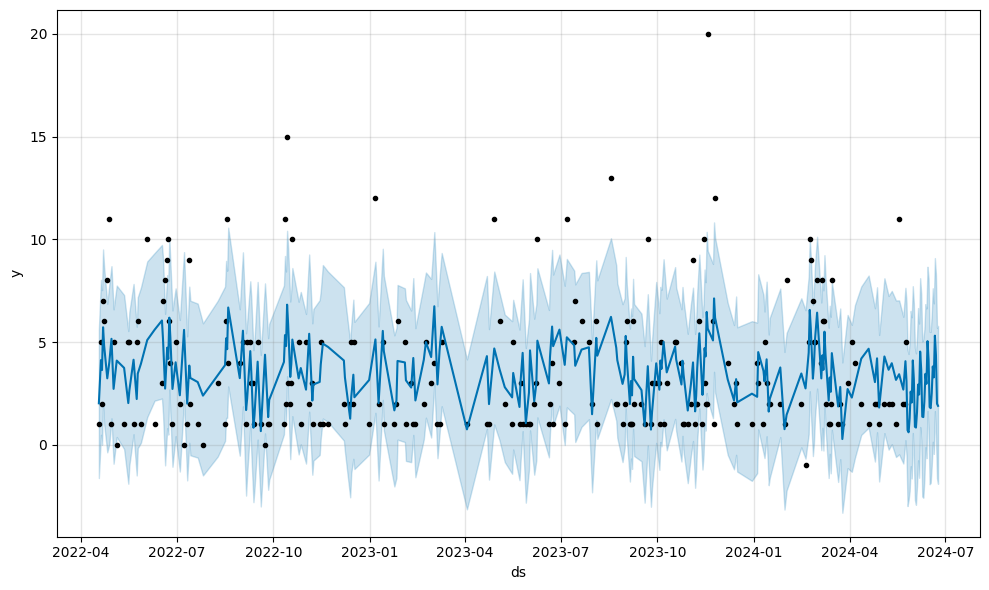

In [7]:
fig1 = m.plot(forecast)

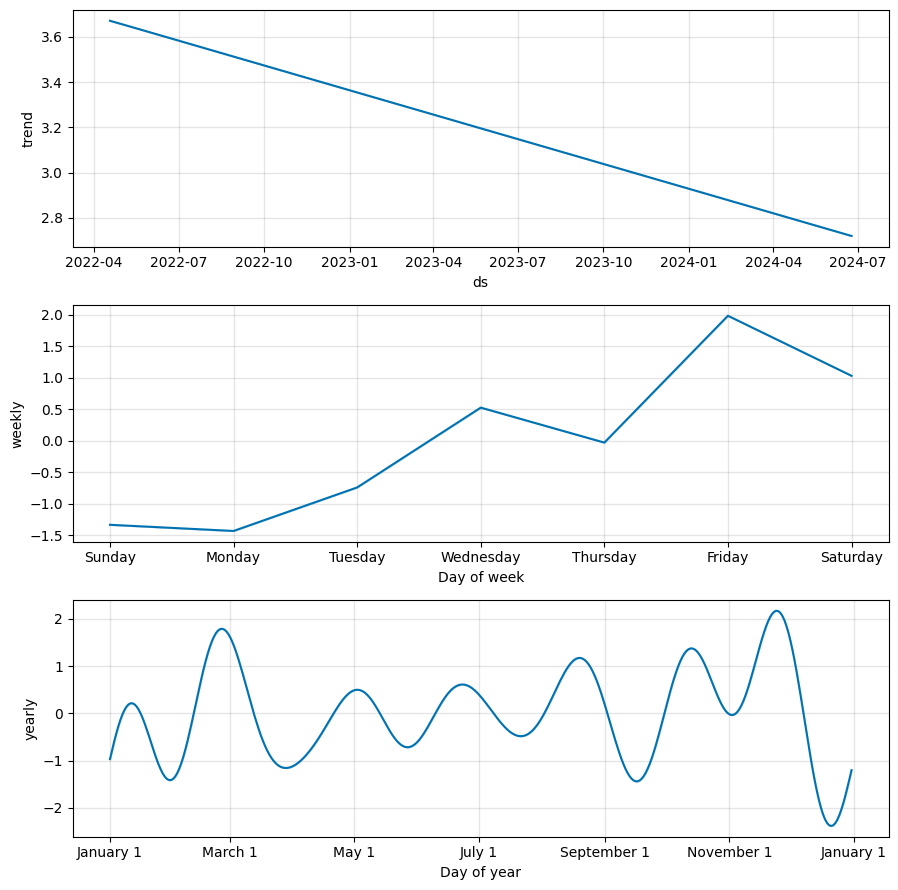

In [8]:
fig2 = m.plot_components(forecast)

In [9]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [10]:
plot_components_plotly(m, forecast)

In [11]:
from prophet.serialize import model_to_json, model_from_json

with open('prophet_model.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

with open('prophet_model.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model

In [12]:
m = Prophet(growth='flat')

,actual,predicted
219,1.0,3.156688
220,11.0,3.432333
221,2.0,2.683197
222,2.0,4.066388
223,5.0,3.088268


Mean Squared Error (MSE): 8.434534786613652
Root Mean Squared Error (RMSE): 2.904227054934523


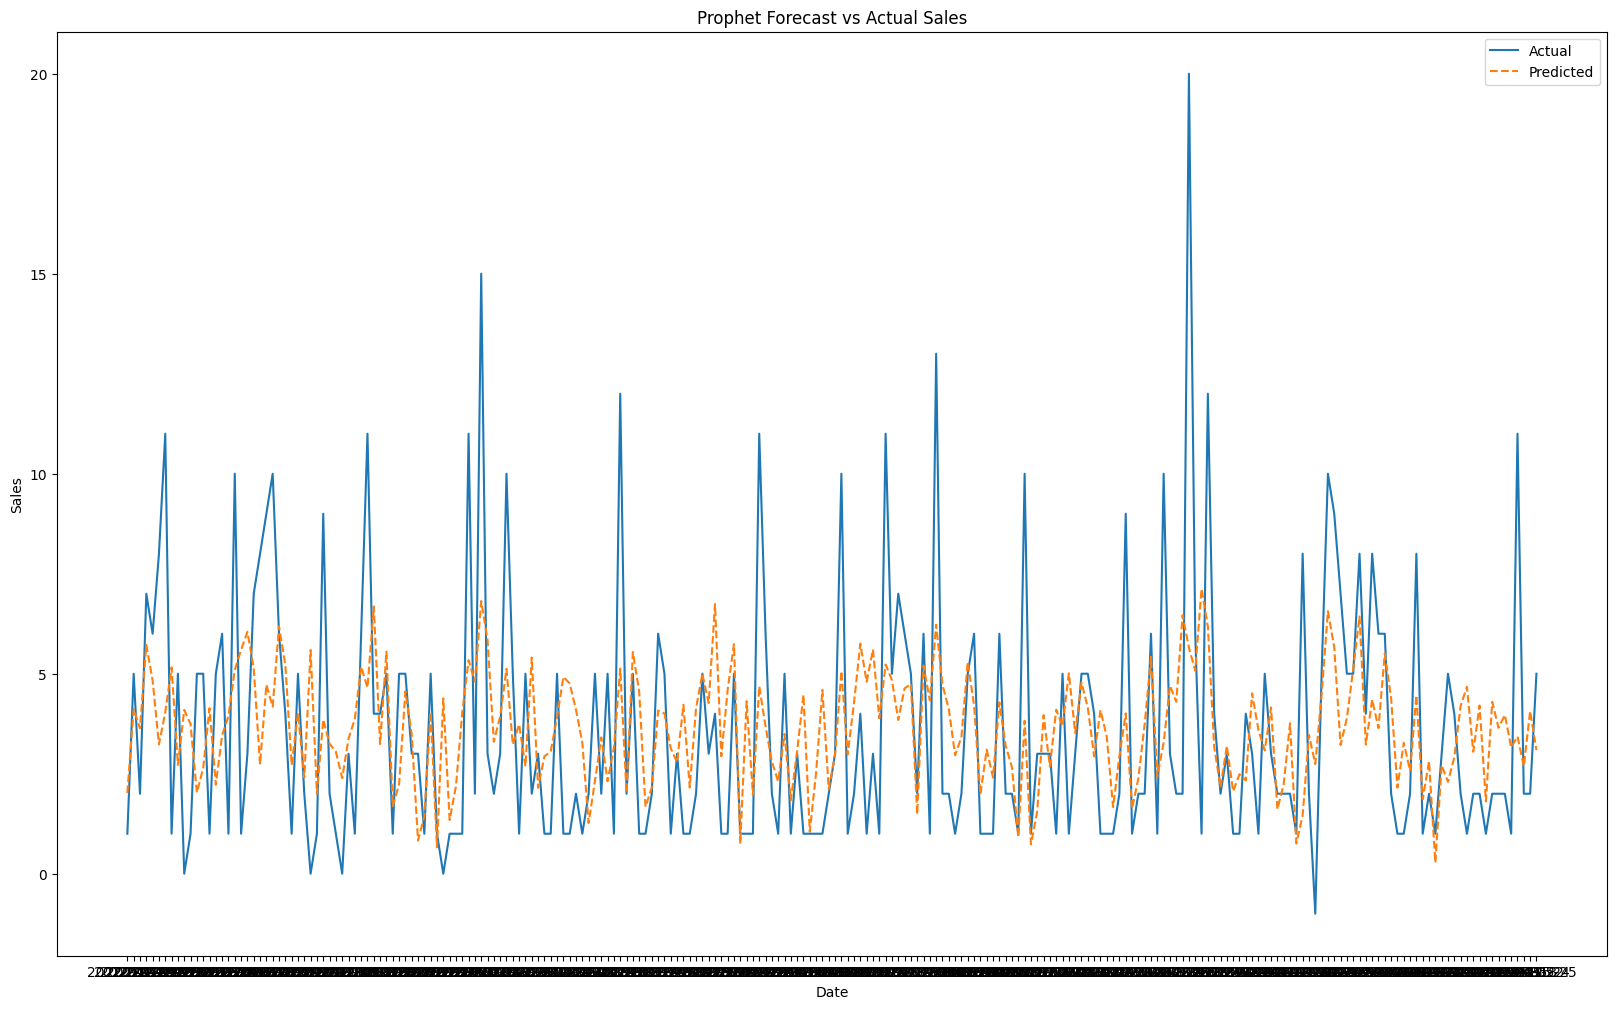

In [24]:
from sklearn.metrics import mean_squared_error
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# Extraer los valores reales y predichos para el cálculo del RMSE
y_true = df_prophet['y'].values  # Valores reales de ventas
y_pred = forecast['yhat'].iloc[:len(y_true)].values  # Predicciones del modelo Prophet

df_comparison = pd.DataFrame({
    'actual': y_true,
    'predicted': y_pred
})

# Si estás utilizando un entorno como Jupyter, puedes usar display para un mejor formato
from IPython.display import display
display(df_comparison.tail(5))

# Mostrar las métricas de error
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Graficar las predicciones vs los valores reales (opcional)
plt.figure(figsize=(20, 12))
plt.plot(df_prophet['ds'], y_true, label='Actual')
plt.plot(df_prophet['ds'], y_pred, label='Predicted', linestyle='--')
plt.title('Prophet Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()